<a href="https://colab.research.google.com/github/adimyth/interesting_stuff/blob/master/tensorflow/mixed_data_input_regression_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tf-nightly-gpu-2.0-preview

In [0]:
!mkdir data

In [10]:
!git clone https://github.com/emanhamed/Houses-dataset data

Cloning into 'data'...
remote: Enumerating objects: 2166, done.
remote: Total 2166 (delta 0), reused 0 (delta 0), pack-reused 2166
Receiving objects: 100% (2166/2166), 176.26 MiB | 8.54 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [11]:
!ls /content/data/Houses\ Dataset | wc -l

2141


## Imports

In [0]:
import locale
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
import tensorflow as tf
from tqdm import tqdm

## Constants

In [0]:
HEIGHT = 32
WIDTH = 32
DEPTH = 3
EPOCHS = 30
BATCH_SIZE = 8

In [0]:
cols = ["bedrooms", "bathrooms", "area", "zipcode", "price"]
data = pd.read_csv('data/Houses Dataset/HousesInfo.txt', sep=' ', header=None, names=cols)

In [0]:
path = []
for i in data.index.values:
		path.append(os.path.sep.join(['data/Houses Dataset', "{}_frontal.jpg".format(i + 1)]))
data['image_path'] = path

In [0]:
path = []
for i in data.index.values:
  intermediate_paths = []
  for x in ['bathroom', 'bedroom', 'frontal', 'kitchen']:
    intermediate_paths.append(os.path.sep.join([f'data/Houses Dataset', "{0}_{1}.jpg".format(i + 1, x)]))
  path.append(intermediate_paths)
data['all_image_path'] = path

In [17]:
data.head()

bedrooms  ...                                     all_image_path
0         4  ...  [data/Houses Dataset/1_bathroom.jpg, data/Hous...
1         4  ...  [data/Houses Dataset/2_bathroom.jpg, data/Hous...
2         3  ...  [data/Houses Dataset/3_bathroom.jpg, data/Hous...
3         5  ...  [data/Houses Dataset/4_bathroom.jpg, data/Hous...
4         3  ...  [data/Houses Dataset/5_bathroom.jpg, data/Hous...

[5 rows x 7 columns]

In [0]:
# returns a tabular model without regression unit
def tabular_model(dim):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(8, input_dim=dim, activation="relu"))
  model.add(tf.keras.layers.Dense(4, activation="relu"))
  return model

In [0]:
# returns a cnn without regression unit
def cnn_model(width, height, depth, filters=(16, 32, 64)):
  inputs = tf.keras.layers.Input(shape=(height, width, depth))
  x = tf.keras.layers.Conv2D(16, (3, 3), padding="same")(inputs)
  x = tf.keras.layers.Activation("relu")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

  x = tf.keras.layers.Conv2D(32, (3, 3), padding="same")(x)
  x = tf.keras.layers.Activation("relu")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

  x = tf.keras.layers.Conv2D(64, (3, 3), padding="same")(x)
  x = tf.keras.layers.Activation("relu")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(16)(x)
  x = tf.keras.layers.Activation("relu")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.5)(x)

  x = tf.keras.layers.Dense(4)(x)
  x = tf.keras.layers.Activation("relu")(x)
  model = tf.keras.Model(inputs, x)
  return model

In [0]:
# this model trains on the concatenated input
def top_model(combined_input):
  x = tf.keras.layers.Dense(32, activation='relu')(combined_input)
  x = tf.keras.layers.Dense(16, activation='relu')(x)
  x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
  return x

In [0]:
# returns numpy array of images for a single view (eg. frontal for all samples)
def load_images(data, field, height, width, depth):
  images = []
  for idx in tqdm(data.index.values):
    img = tf.io.read_file(data[field].iloc[idx])
    img = tf.image.decode_jpeg(img, channels=depth)
    img = tf.image.resize(img, [height, width])
    images.append(img)
  return np.array(images)

In [0]:
# helper function
def process_single_image(path, height, width, depth):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=depth)
  img = tf.image.resize(img, [height, width])
  return img

Scaling continous data & one-hot encoding categorical data

In [0]:
def treat_tab_data(data):
	continuous = ["bedrooms", "bathrooms", "area"]
	cs = MinMaxScaler()
	continous_data = cs.fit_transform(data[continuous])
 
	zipBinarizer = LabelBinarizer().fit(data["zipcode"])
	categorical_data = zipBinarizer.transform(data["zipcode"])
 
	data = np.hstack([continous_data, categorical_data]) 
	return data

Returns a `montage` for each sample with `bathroom, bedroom, frontal & kitchen` images stitched in a clock-wise manner

In [0]:
def load_image_montages(data, field, height, width, depth):
  images = []
  for idx in tqdm(data.index.values):
    image_paths = data[field].iloc[idx]
    intermediate_images = []
    for path in image_paths:
      img = process_single_image(path, height, width, depth)
      intermediate_images.append(img)
    
    outputImage = np.zeros((2*height, 2*width, depth), dtype="uint8")
    outputImage[0:height, 0:width] = intermediate_images[0]
    outputImage[0:height, width:2*width] = intermediate_images[1]
    outputImage[height:2*height, width:2*width] = intermediate_images[2]
    outputImage[height:2*height, 0:width] = intermediate_images[3]
    images.append(outputImage)
  return np.array(images)

A duplicate of `load_images` function, except that it returns a list instead of numpy array, as converting a list of images to numpy array takes too long. Surprisingly, the time taken for `np.array(list_of_images)` keeps on increasing as the size of image keeps on increasing.

In [0]:
def load_frontal_image(data, field, height, width, depth):
  images = []
  for idx in tqdm(data.index.values):
    img = process_single_image(data[field].iloc[idx], height, width, depth)
    images.append(img)
  return images

Given predictions & actual values, plots an image of actual house with predicted & actual prices

In [0]:
def plot_random_images(predictions, target, data):
  random_indices = np.random.randint(low=0, high=535, size=5)
  for idx in random_indices:
    plt.imshow(np.array(data[idx], np.int32))
    plt.title(f"Image:  {idx}\nActual: ${target.values[idx]}\nPredicted: ${np.round(predictions[idx][0], 2)}")
    plt.show()

In [27]:
tabular_data = data.copy()
images_data = load_images(data, 'image_path', HEIGHT, WIDTH, DEPTH)

100%|██████████| 535/535 [00:03<00:00, 134.07it/s]


In [28]:
images_montage_data = load_image_montages(tabular_data, 'all_image_path', HEIGHT, WIDTH, DEPTH)

100%|██████████| 535/535 [00:09<00:00, 55.15it/s]


In [29]:
plot_montage_data = load_image_montages(tabular_data, 'all_image_path', 256, 256, DEPTH)

100%|██████████| 535/535 [00:12<00:00, 42.78it/s]


In [0]:
target = tabular_data.price

In [0]:
tab_data = treat_tab_data(data)

## Mixed Input

### Tabular Data + Frontal Image Data

In [0]:
mlp = tabular_model(52)
cnn = cnn_model(WIDTH, HEIGHT, DEPTH)

In [0]:
combined_input = tf.keras.layers.concatenate([mlp.output, cnn.output])

In [0]:
output = top_model(combined_input) 

In [0]:
model = tf.keras.Model(inputs=[mlp.input, cnn.input], outputs=output)

In [0]:
opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

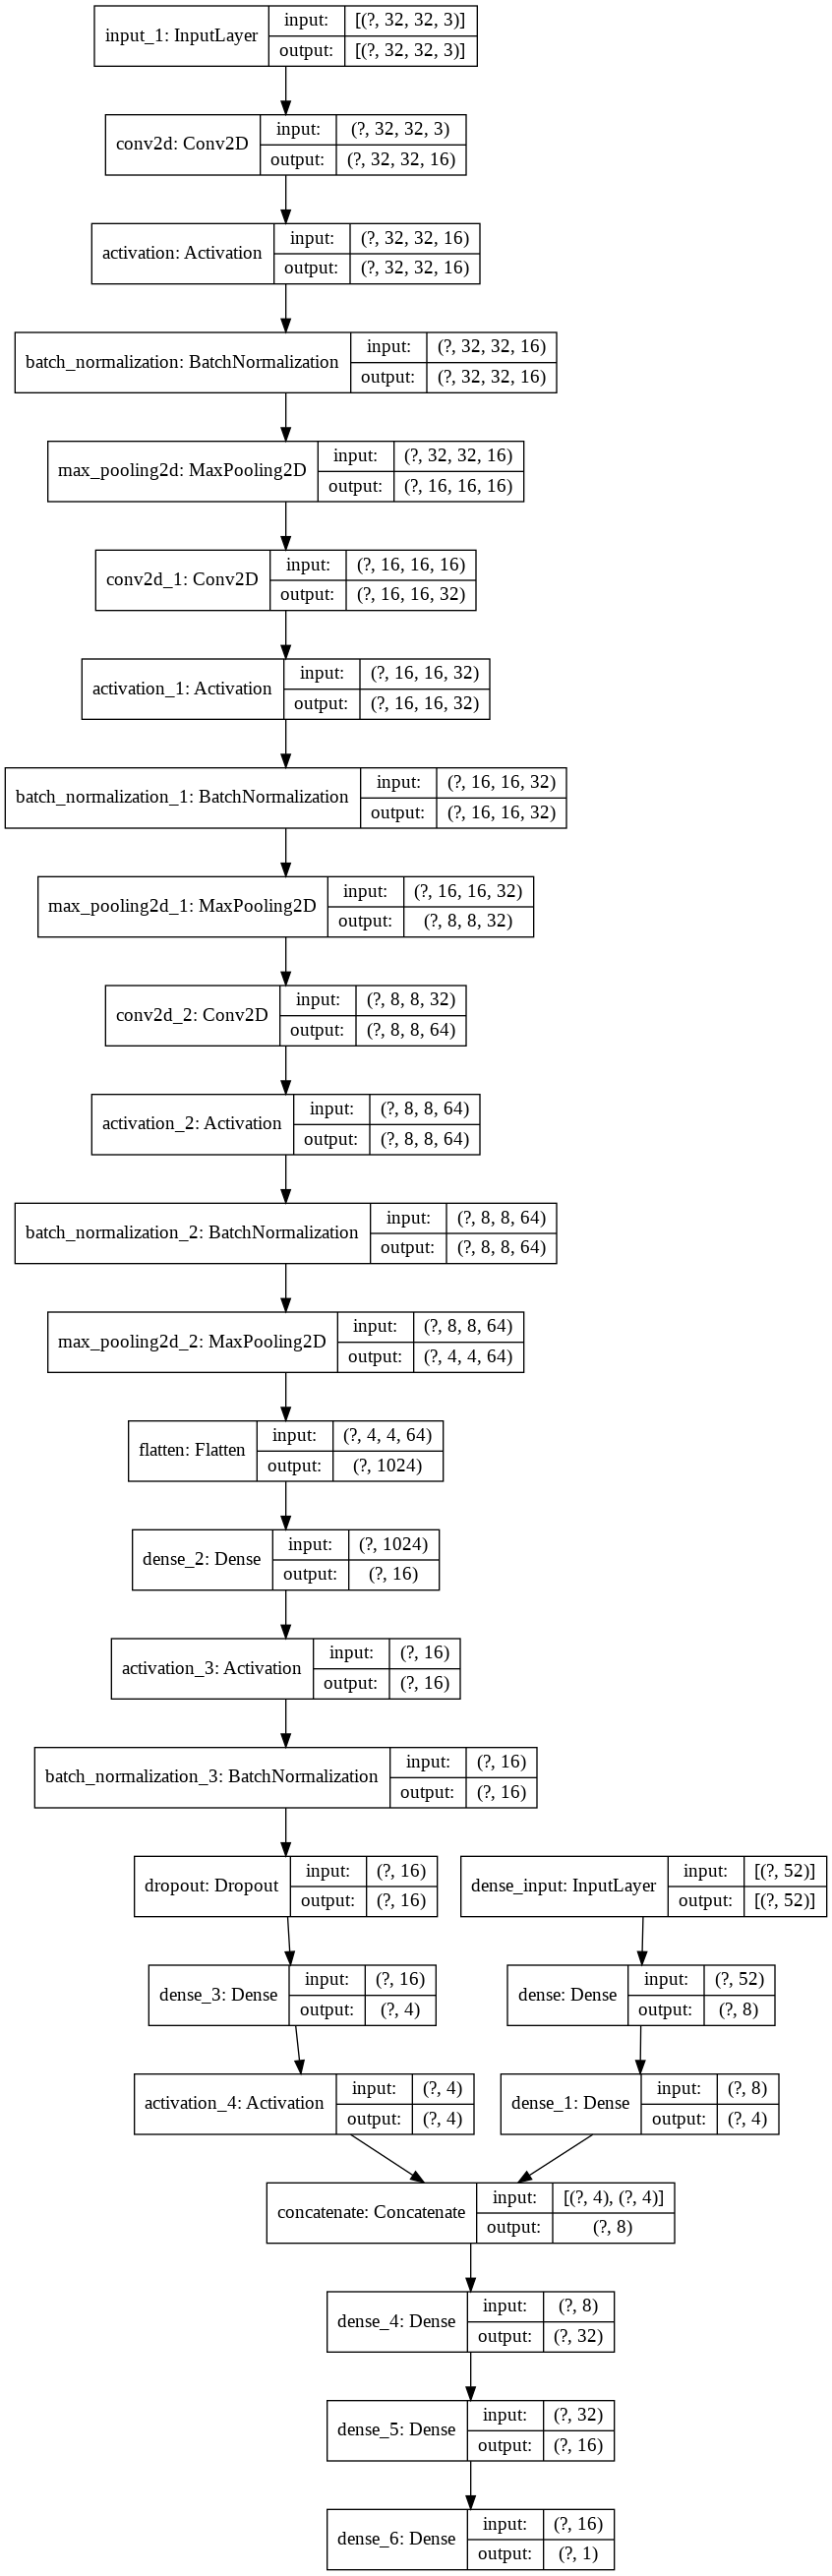

In [37]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [38]:
model.fit([tab_data, images_data], target.values/target.max(), epochs=EPOCHS, batch_size=BATCH_SIZE)

Train on 535 samples
Epoch 1/30
535/535 [==============================] - 5s 10ms/sample - loss: 458.4643
Epoch 2/30
535/535 [==============================] - 0s 660us/sample - loss: 118.8935
Epoch 3/30
535/535 [==============================] - 0s 691us/sample - loss: 80.2213
Epoch 4/30
535/535 [==============================] - 0s 634us/sample - loss: 74.2847
Epoch 5/30
535/535 [==============================] - 0s 646us/sample - loss: 64.3152
Epoch 6/30
535/535 [==============================] - 0s 650us/sample - loss: 55.0679
Epoch 7/30
535/535 [==============================] - 0s 655us/sample - loss: 51.5516
Epoch 8/30
535/535 [==============================] - 0s 685us/sample - loss: 43.3074
Epoch 9/30
535/535 [==============================] - 0s 718us/sample - loss: 45.9613
Epoch 10/30
535/535 [==============================] - 0s 636us/sample - loss: 42.7354
Epoch 11/30
535/535 [==============================] - 0s 663us/sample - loss: 40.8349
Epoch 12/30
535/535 [=========

In [0]:
preds = model.predict([tab_data, images_data])
predictions = preds*target.max()

In [40]:
frontal_data = load_frontal_image(data, 'image_path', 256, 256, DEPTH)

100%|██████████| 535/535 [00:02<00:00, 192.40it/s]


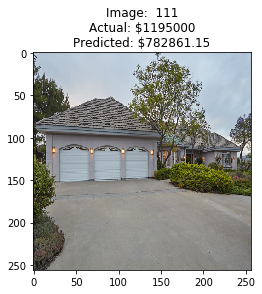

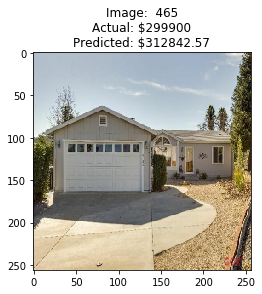

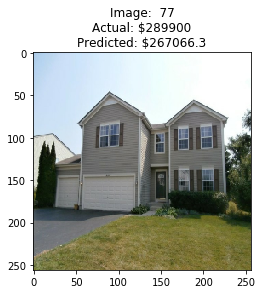

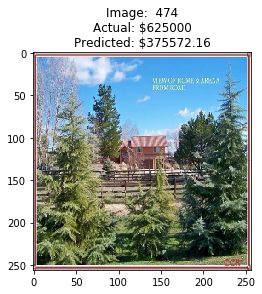

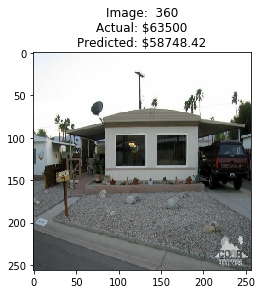

In [41]:
plot_random_images(predictions, target, frontal_data)

### Tabular Data + Montage Image Data

Training a model on the combination of tabular data & all 4 (bathroom, bedroom,  frontal, kitchen) images stitched together

In [0]:
mlp = tabular_model(52)
cnn = cnn_model(64, 64, DEPTH)

In [0]:
combined_input = tf.keras.layers.concatenate([mlp.output, cnn.output])

In [0]:
output = top_model(combined_input) 

In [0]:
model = tf.keras.Model(inputs=[mlp.input, cnn.input], outputs=output)

In [0]:
opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

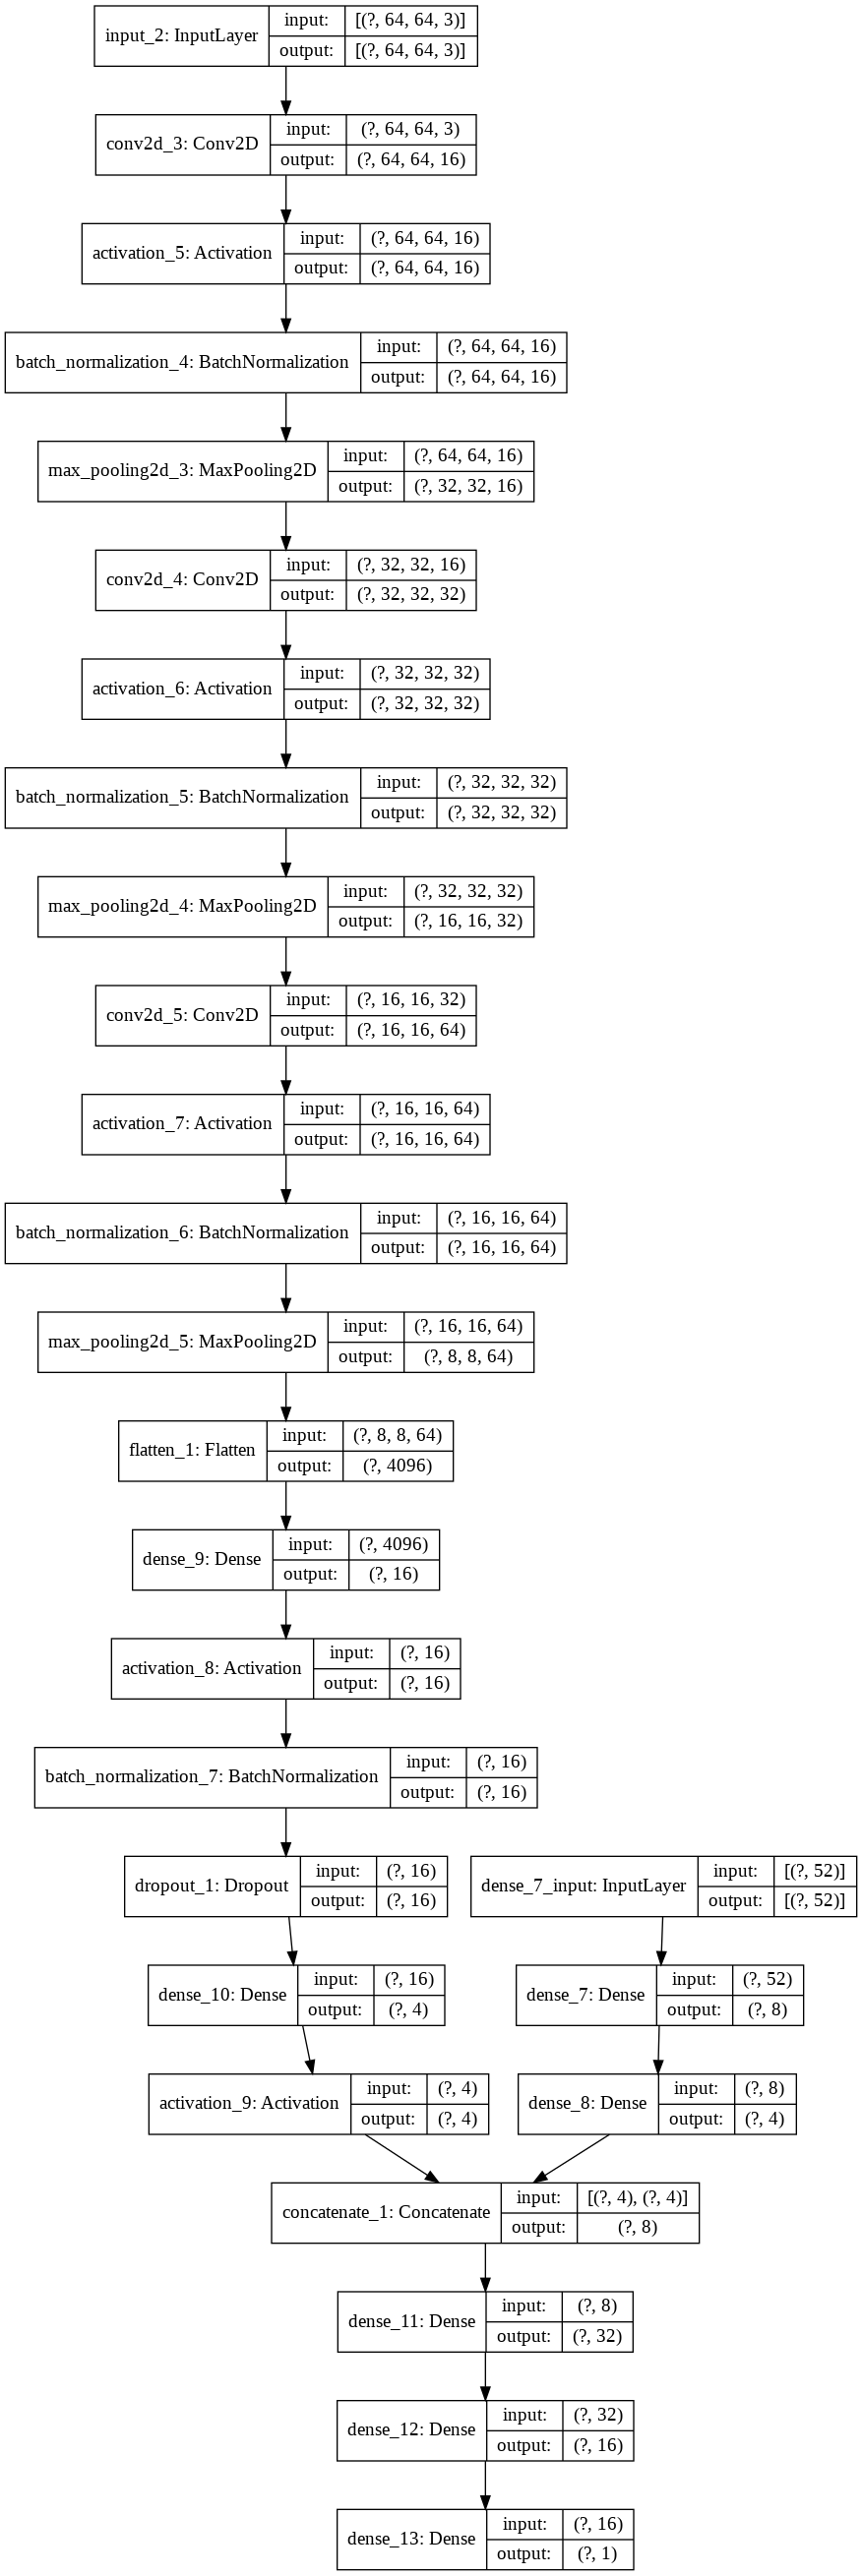

In [47]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [48]:
model.fit([tab_data, images_montage_data], target.values/target.max(), epochs=EPOCHS, batch_size=BATCH_SIZE)

Train on 535 samples
Epoch 1/30
535/535 [==============================] - 1s 3ms/sample - loss: 854.3170
Epoch 2/30
535/535 [==============================] - 0s 631us/sample - loss: 193.4924
Epoch 3/30
535/535 [==============================] - 0s 633us/sample - loss: 72.0374
Epoch 4/30
535/535 [==============================] - 0s 686us/sample - loss: 69.1206
Epoch 5/30
535/535 [==============================] - 0s 632us/sample - loss: 66.5004
Epoch 6/30
535/535 [==============================] - 0s 652us/sample - loss: 55.8831
Epoch 7/30
535/535 [==============================] - 0s 681us/sample - loss: 48.6408
Epoch 8/30
535/535 [==============================] - 0s 637us/sample - loss: 47.1448
Epoch 9/30
535/535 [==============================] - 0s 673us/sample - loss: 39.9752
Epoch 10/30
535/535 [==============================] - 0s 681us/sample - loss: 36.2681
Epoch 11/30
535/535 [==============================] - 0s 651us/sample - loss: 33.6596
Epoch 12/30
535/535 [==========

In [0]:
images_montage_data = images_montage_data.astype('float32')

In [0]:
preds = model.predict([tab_data, images_montage_data])
predictions = preds*target.max()

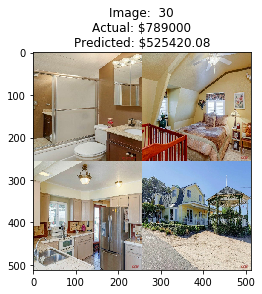

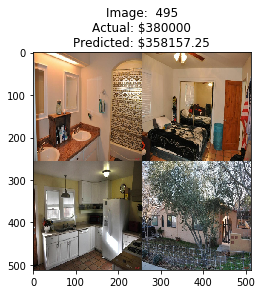

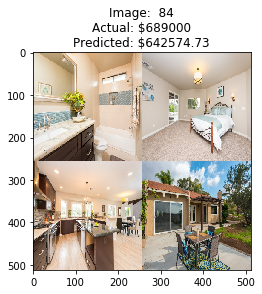

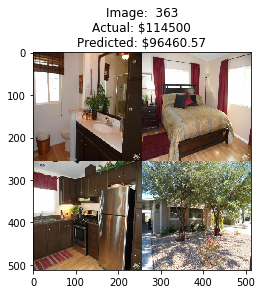

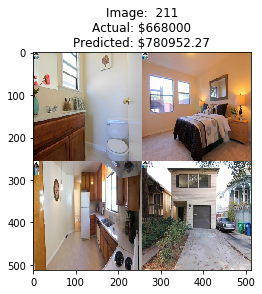

In [51]:
plot_random_images(predictions, target, plot_montage_data)

## Single Input

### Tabular Data Only

We are not performing any kind of preprocessing or transformation, such as normalization, scaling, etc

In [0]:
def get_tabular_model(dim):
  tab_model = tf.keras.Sequential()
  tab_model.add(tf.keras.layers.Dense(64, input_dim=dim, activation='relu'))
  tab_model.add(tf.keras.layers.Dense(32, activation='relu'))
  tab_model.add(tf.keras.layers.Dense(8, activation='relu'))
  tab_model.add(tf.keras.layers.Dense(1, activation='linear'))
  return tab_model

In [0]:
tabular_model = get_tabular_model(52)
tabular_model.compile(optimizer=opt, loss='mean_absolute_percentage_error')

In [54]:
tabular_model.fit(tab_data, tabular_data['price'].values/tabular_data['price'].max(), epochs=20)

Train on 535 samples
Epoch 1/20
535/535 [==============================] - 0s 603us/sample - loss: 52.0965
Epoch 2/20
535/535 [==============================] - 0s 84us/sample - loss: 34.9391
Epoch 3/20
535/535 [==============================] - 0s 77us/sample - loss: 31.6170
Epoch 4/20
535/535 [==============================] - 0s 81us/sample - loss: 30.9106
Epoch 5/20
535/535 [==============================] - 0s 80us/sample - loss: 26.6178
Epoch 6/20
535/535 [==============================] - 0s 81us/sample - loss: 25.9638
Epoch 7/20
535/535 [==============================] - 0s 79us/sample - loss: 24.4332
Epoch 8/20
535/535 [==============================] - 0s 78us/sample - loss: 24.9681
Epoch 9/20
535/535 [==============================] - 0s 82us/sample - loss: 25.4407
Epoch 10/20
535/535 [==============================] - 0s 77us/sample - loss: 23.0065
Epoch 11/20
535/535 [==============================] - 0s 77us/sample - loss: 24.3303
Epoch 12/20
535/535 [====================

### Image Data Only

In [0]:
def create_cnn(width, height, depth, regress=False, activation=None):
  inputShape = (height, width, depth)
  inputs = tf.keras.layers.Input(shape=inputShape)
  x = tf.keras.layers.Conv2D(16, (3, 3), padding="same")(inputs)
  x = tf.keras.layers.Activation("relu")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

  x = tf.keras.layers.Conv2D(32, (3, 3), padding="same")(x)
  x = tf.keras.layers.Activation("relu")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

  x = tf.keras.layers.Conv2D(64, (3, 3), padding="same")(x)
  x = tf.keras.layers.Activation("relu")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

  x = tf.keras.layers.Conv2D(128, (3, 3), padding="same")(x)
  x = tf.keras.layers.Activation("relu")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(32)(x)
  x = tf.keras.layers.Dense(16)(x)
  x = tf.keras.layers.Activation("relu")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.5)(x)

  x = tf.keras.layers.Dense(4)(x)
  x = tf.keras.layers.Activation("relu")(x)

  if regress:
    if activation == None:
      x = tf.keras.layers.Dense(1, activation="linear")(x)
    else:
      x = tf.keras.layers.Dense(1, activation=activation)(x)

  model = tf.keras.Model(inputs, x)
  return model

#### Frontal View

In [0]:
cnn_model = create_cnn(HEIGHT, WIDTH, DEPTH, regress=True)
cnn_model.compile(optimizer=opt, loss='mean_absolute_percentage_error')

In [57]:
cnn_model.fit(images_data, tabular_data['price'].values/tabular_data['price'].max(), epochs=EPOCHS)

Train on 535 samples
Epoch 1/30
535/535 [==============================] - 1s 2ms/sample - loss: 1147.0295
Epoch 2/30
535/535 [==============================] - 0s 194us/sample - loss: 432.6282
Epoch 3/30
535/535 [==============================] - 0s 170us/sample - loss: 397.6758
Epoch 4/30
535/535 [==============================] - 0s 177us/sample - loss: 225.7151
Epoch 5/30
535/535 [==============================] - 0s 181us/sample - loss: 223.6306
Epoch 6/30
535/535 [==============================] - 0s 180us/sample - loss: 178.7293
Epoch 7/30
535/535 [==============================] - 0s 199us/sample - loss: 169.9991
Epoch 8/30
535/535 [==============================] - 0s 223us/sample - loss: 157.2574
Epoch 9/30
535/535 [==============================] - 0s 178us/sample - loss: 138.8272
Epoch 10/30
535/535 [==============================] - 0s 204us/sample - loss: 124.7684
Epoch 11/30
535/535 [==============================] - 0s 224us/sample - loss: 121.2293
Epoch 12/30
535/535 [

In [0]:
preds = cnn_model.predict(images_data)
predictions = preds*tabular_data['price'].max()

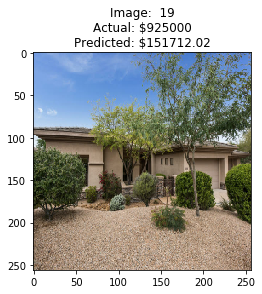

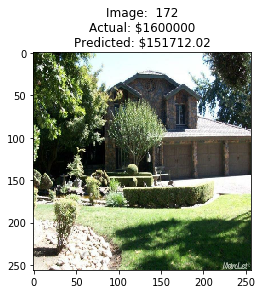

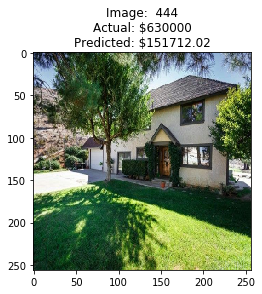

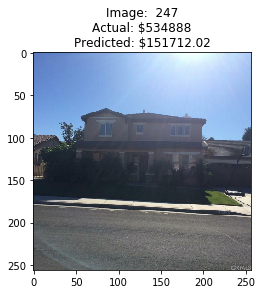

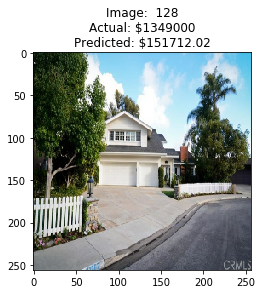

In [59]:
plot_random_images(predictions, target, frontal_data)

**CNN model when given only `Frontal` image view struggles, as compared to the previous results**

#### All Views

In [0]:
cnn_model = create_cnn(64, 64, 3, regress=True, activation='sigmoid')
cnn_model.compile(optimizer=opt, loss='mean_absolute_percentage_error')

In [61]:
cnn_model.fit(images_montage_data, tabular_data['price'].values/tabular_data['price'].max(), epochs=EPOCHS)

Train on 535 samples
Epoch 1/30
535/535 [==============================] - 1s 2ms/sample - loss: 462.9714
Epoch 2/30
535/535 [==============================] - 0s 222us/sample - loss: 184.1283
Epoch 3/30
535/535 [==============================] - 0s 210us/sample - loss: 121.8179
Epoch 4/30
535/535 [==============================] - 0s 217us/sample - loss: 95.7126
Epoch 5/30
535/535 [==============================] - 0s 205us/sample - loss: 84.7673
Epoch 6/30
535/535 [==============================] - 0s 211us/sample - loss: 100.3178
Epoch 7/30
535/535 [==============================] - 0s 212us/sample - loss: 87.3888
Epoch 8/30
535/535 [==============================] - 0s 207us/sample - loss: 89.8018
Epoch 9/30
535/535 [==============================] - 0s 214us/sample - loss: 90.2670
Epoch 10/30
535/535 [==============================] - 0s 208us/sample - loss: 92.2294
Epoch 11/30
535/535 [==============================] - 0s 209us/sample - loss: 90.5165
Epoch 12/30
535/535 [========

In [0]:
preds = cnn_model.predict(images_montage_data)
predictions = preds*tabular_data['price'].max()

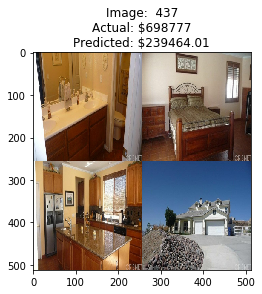

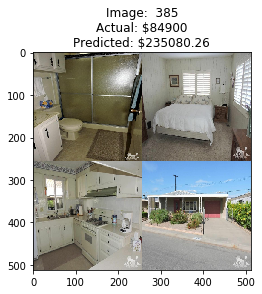

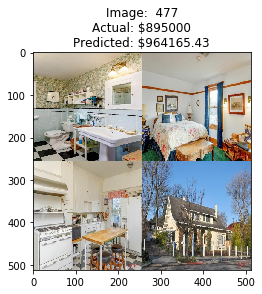

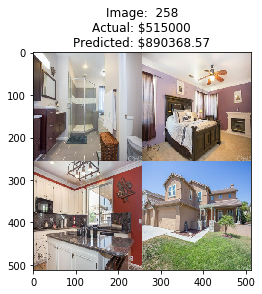

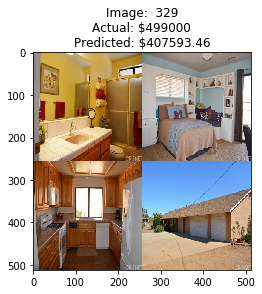

In [63]:
plot_random_images(predictions, target, plot_montage_data)

# MobileNet (ImageNet)

In [71]:
tl_data = load_image_montages(tabular_data, 'all_image_path', 80, 80, DEPTH)

100%|██████████| 535/535 [00:11<00:00, 45.88it/s]


In [65]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(160, 160, 3),
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 2s 0us/step


In [0]:
base_model.trainable = False

In [0]:
model = tf.keras.Sequential([
                             base_model,
                             tf.keras.layers.GlobalAveragePooling2D(),
                             tf.keras.layers.Dense(32, activation='relu'),
                             tf.keras.layers.Dense(16, activation='relu'),
                             tf.keras.layers.Dense(1, activation='linear')
])

In [0]:
opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

In [75]:
model.fit(tl_data, tabular_data['price'].values/tabular_data['price'].max(), epochs=EPOCHS)

Train on 535 samples
Epoch 1/30
535/535 [==============================] - 2s 4ms/sample - loss: 370.1233
Epoch 2/30
535/535 [==============================] - 0s 740us/sample - loss: 156.3564
Epoch 3/30
535/535 [==============================] - 0s 737us/sample - loss: 133.7082
Epoch 4/30
535/535 [==============================] - 0s 722us/sample - loss: 107.2127
Epoch 5/30
535/535 [==============================] - 0s 732us/sample - loss: 110.4076
Epoch 6/30
535/535 [==============================] - 0s 751us/sample - loss: 89.2768
Epoch 7/30
535/535 [==============================] - 0s 741us/sample - loss: 82.5870
Epoch 8/30
535/535 [==============================] - 0s 729us/sample - loss: 72.3369
Epoch 9/30
535/535 [==============================] - 0s 727us/sample - loss: 62.1792
Epoch 10/30
535/535 [==============================] - 0s 735us/sample - loss: 74.2757
Epoch 11/30
535/535 [==============================] - 0s 734us/sample - loss: 59.8643
Epoch 12/30
535/535 [=======

In [0]:
preds = model.predict(tl_data.astype('float32'))
predictions = preds*tabular_data['price'].max()

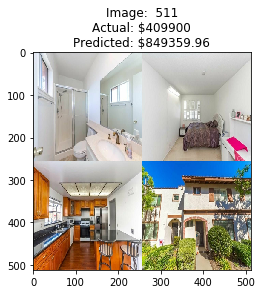

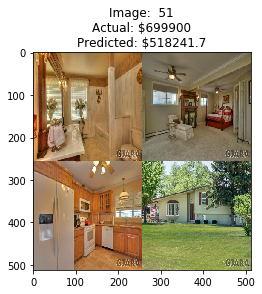

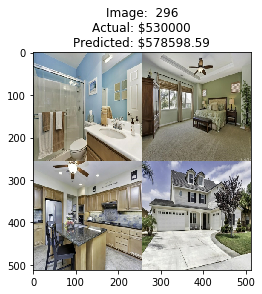

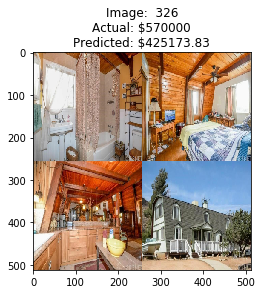

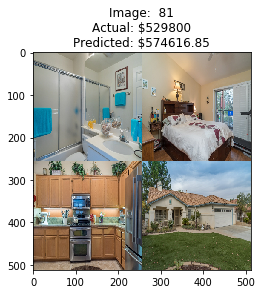

In [79]:
plot_random_images(predictions, target, plot_montage_data)

# Conclusion

Definitely the results are not good. There are many those are quite correct & some that are very far away. 

* Hyperparameter Tuning
* Will try loss function other then `MAPE`
* Better architecture
* A better strategy to pass all the images as input at once; other then stitching them into one